In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 26 kB/s 
     |████████████████████████████████| 198 kB 56.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=8080a25815cafb80fdf1d9133114854d09ba6d138eb4cf29db8d41458f379250
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import matplotlib                  # 2D Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns              # Python Data Visualization Library based on matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline
# ML Libraries
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [3]:
conf = pyspark.SparkConf()
conf.setAppName('mySparkApp')
conf.setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [4]:
!wget -q http://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip

In [5]:
!unzip dataset_diabetes.zip

Archive:  dataset_diabetes.zip
  inflating: dataset_diabetes/diabetic_data.csv  
  inflating: dataset_diabetes/IDs_mapping.csv  


In [6]:
diabetes_df = spark.read.option('header','true').csv('/content/dataset_diabetes/diabetic_data.csv',inferSchema=True)

In [7]:
diabetes_df.show()

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [8]:
diabetes_df.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-

In [9]:
expr = [f.countDistinct(c).alias(c) for c in diabetes_df.columns]
countdf =  diabetes_df.select(*expr)

In [10]:
countdf.show()

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [11]:
diabetes_df = diabetes_df.drop('weight','payer_code','medical_specialty')

In [12]:
meds = diabetes_df.columns[21:-3]

In [13]:
for i in meds:
    percent_No = (diabetes_df.filter(diabetes_df[i] == "No").groupby().count().first()[0]/diabetes_df.groupby().count().first()[0])*100
    if percent_No > 99.0:
        print(i, percent_No)
        diabetes_df = diabetes_df.drop(i)

nateglinide 99.30919953619087
chlorpropamide 99.91549240414284
acetohexamide 99.99901735353654
tolbutamide 99.97739913134053
acarbose 99.69734488925575
miglitol 99.9626594343887
troglitazone 99.99705206060963
tolazamide 99.96167678792524
examide 100.0
citoglipton 100.0
glyburide-metformin 99.3062515968005
glipizide-metformin 99.98722559597508
glimepiride-pioglitazone 99.99901735353654
metformin-rosiglitazone 99.99803470707309
metformin-pioglitazone 99.99901735353654


In [14]:
diabetes_df.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- 

In [15]:
#diabetes_df.agg(f.count_distinct(i for i in diabetes_df.columns).alias('c')).collect()
for i in diabetes_df.columns:
    count_unqiue = diabetes_df.agg(f.count_distinct(i).alias('c')).collect()[0][0]
    print(i, count_unqiue)#.first()[0])
    if count_unqiue < 20:
        print(diabetes_df.select(i).distinct().collect())

encounter_id 101766
patient_nbr 71518
race 6
[Row(race='Caucasian'), Row(race='Other'), Row(race='AfricanAmerican'), Row(race='Hispanic'), Row(race='Asian'), Row(race='?')]
gender 3
[Row(gender='Female'), Row(gender='Unknown/Invalid'), Row(gender='Male')]
age 10
[Row(age='[70-80)'), Row(age='[90-100)'), Row(age='[40-50)'), Row(age='[10-20)'), Row(age='[20-30)'), Row(age='[30-40)'), Row(age='[0-10)'), Row(age='[80-90)'), Row(age='[50-60)'), Row(age='[60-70)')]
admission_type_id 8
[Row(admission_type_id=1), Row(admission_type_id=6), Row(admission_type_id=3), Row(admission_type_id=5), Row(admission_type_id=4), Row(admission_type_id=8), Row(admission_type_id=7), Row(admission_type_id=2)]
discharge_disposition_id 26
admission_source_id 17
[Row(admission_source_id=22), Row(admission_source_id=1), Row(admission_source_id=13), Row(admission_source_id=6), Row(admission_source_id=3), Row(admission_source_id=20), Row(admission_source_id=5), Row(admission_source_id=17), Row(admission_source_id=9),

In [16]:
diabetes_df_2 = diabetes_df
from pyspark.sql.functions import when
from pyspark.sql.types import FloatType

diabetes_df_2 = diabetes_df_2.withColumn("race", \
              when(diabetes_df_2["race"] == '?', None).otherwise(diabetes_df_2['race']))
diabetes_df_2 = diabetes_df_2.withColumn("diag_1", \
              when(diabetes_df_2["diag_1"] == '?', None).otherwise(diabetes_df_2['diag_1']))
diabetes_df_2 = diabetes_df_2.withColumn("diag_2", \
              when(diabetes_df_2["diag_2"] == '?', None).otherwise(diabetes_df_2['diag_2']))
diabetes_df_2 = diabetes_df_2.withColumn("diag_3", \
              when(diabetes_df_2["diag_3"] == '?', None).otherwise(diabetes_df_2['diag_3']))
diabetes_df_2 = diabetes_df_2.withColumn("diag_1",diabetes_df_2["diag_1"].cast(FloatType()))
diabetes_df_2 = diabetes_df_2.withColumn("diag_2",diabetes_df_2["diag_2"].cast(FloatType()))
diabetes_df_2 = diabetes_df_2.withColumn("diag_3",diabetes_df_2["diag_3"].cast(FloatType()))
diabetes_df_2.show()

+------------+-----------+---------------+------+--------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+---------+---------+------------+-------------+-------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|glimepiride|glipizide|glyburide|pioglitazone|rosiglitazone|insulin|change|diabetesMed|readmitted|
+------------+-----------+---------------+------+--------+-----------------+------------------------+-------------------+----------------+------------------

In [17]:
# for i in diabetes_df_2.columns:
#     count_unqiue = diabetes_df_2.agg(f.count_distinct(i).alias('c')).collect()[0][0]
#     print(i, count_unqiue)#.first()[0])
#     if count_unqiue < 20:
#         print(diabetes_df_2.select(i).distinct().collect())
diabetes_df_2.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: float (nullable = true)
 |-- diag_2: float (nullable = true)
 |-- diag_3: float (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- rep

In [18]:
diabetes_df_2.select([f.count(when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in diabetes_df_2.columns]
   ).show()


+------------+-----------+----+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+---------+---------+------------+-------------+-------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|glimepiride|glipizide|glyburide|pioglitazone|rosiglitazone|insulin|change|diabetesMed|readmitted|
+------------+-----------+----+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+----------------

In [19]:
diabetes_pd_df = diabetes_df_2.toPandas()

In [20]:
diabetes_pd_df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [21]:
diabetes_pd_df['readmitted'] = diabetes_pd_df['readmitted'].replace({'>30':'YES', '<30':'YES'})

In [22]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder() 
for i in diabetes_pd_df.columns:
    if diabetes_pd_df[i].dtype == 'object':
        diabetes_pd_df[i] = labelencoder.fit_transform(diabetes_pd_df[i])
        print(i, diabetes_pd_df[i].dtype) 

race int64
gender int64
age int64
max_glu_serum int64
A1Cresult int64
metformin int64
repaglinide int64
glimepiride int64
glipizide int64
glyburide int64
pioglitazone int64
rosiglitazone int64
insulin int64
change int64
diabetesMed int64
readmitted int64


In [23]:
diabetes_pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   encounter_id              101766 non-null  int32  
 1   patient_nbr               101766 non-null  int32  
 2   race                      101766 non-null  int64  
 3   gender                    101766 non-null  int64  
 4   age                       101766 non-null  int64  
 5   admission_type_id         101766 non-null  int32  
 6   discharge_disposition_id  101766 non-null  int32  
 7   admission_source_id       101766 non-null  int32  
 8   time_in_hospital          101766 non-null  int32  
 9   num_lab_procedures        101766 non-null  int32  
 10  num_procedures            101766 non-null  int32  
 11  num_medications           101766 non-null  int32  
 12  number_outpatient         101766 non-null  int32  
 13  number_emergency          101766 non-null  i

In [24]:
diabetes_pd_df = diabetes_pd_df.dropna(subset = ["diag_1","diag_2"])

In [25]:
diabetes_pd_df["diag_diff"] = ((diabetes_pd_df["diag_2"] - diabetes_pd_df["diag_1"])/diabetes_pd_df["diag_1"])*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
diabetes_pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97429 entries, 1 to 101765
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              97429 non-null  int32  
 1   patient_nbr               97429 non-null  int32  
 2   race                      97429 non-null  int64  
 3   gender                    97429 non-null  int64  
 4   age                       97429 non-null  int64  
 5   admission_type_id         97429 non-null  int32  
 6   discharge_disposition_id  97429 non-null  int32  
 7   admission_source_id       97429 non-null  int32  
 8   time_in_hospital          97429 non-null  int32  
 9   num_lab_procedures        97429 non-null  int32  
 10  num_procedures            97429 non-null  int32  
 11  num_medications           97429 non-null  int32  
 12  number_outpatient         97429 non-null  int32  
 13  number_emergency          97429 non-null  int32  
 14  numbe

In [27]:
matrix = diabetes_pd_df.corr()
print(matrix)

                          encounter_id  patient_nbr  ...  readmitted  diag_diff
encounter_id                  1.000000     0.513795  ...   -0.037029   0.035221
patient_nbr                   0.513795     1.000000  ...    0.074081   0.017519
race                          0.089589     0.109076  ...   -0.020913   0.010141
gender                        0.006736     0.008349  ...   -0.017274  -0.001550
age                           0.071295     0.070741  ...    0.027882   0.020703
admission_type_id            -0.159222    -0.012839  ...   -0.007168  -0.027188
discharge_disposition_id     -0.132088    -0.136570  ...   -0.015717   0.001641
admission_source_id          -0.113446    -0.032136  ...    0.039795   0.012143
time_in_hospital             -0.061031    -0.025382  ...    0.050692   0.044181
num_lab_procedures           -0.024404     0.018696  ...    0.039151   0.042229
num_procedures               -0.015270    -0.019286  ...   -0.046295  -0.027182
num_medications               0.074673  

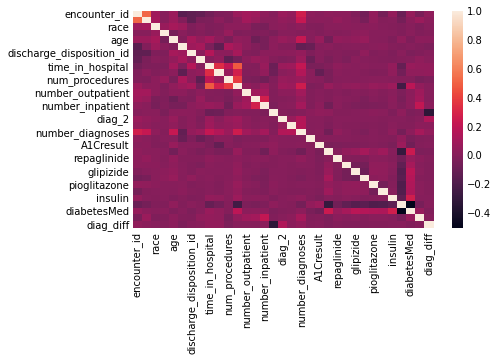

In [28]:
sns.heatmap(matrix, annot=False)
plt.show()

In [59]:
drop_col = ["encounter_id","patient_nbr","diag_1","diag_2","diag_3","readmitted"]

In [60]:
accuracy = []

In [61]:
X = diabetes_pd_df.drop(columns = drop_col)
y = diabetes_pd_df.readmitted

In [62]:
min_max_scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(min_max_scaler.fit_transform(X))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

In [64]:
ran_for = RandomForestClassifier(random_state=123)

ran_for.fit(X_train, y_train)

preds = ran_for.predict(X_test)

print(accuracy_score(y_test, preds))
accuracy.append(accuracy_score(y_test, preds))

0.6332751719183003


In [65]:
grad_boost = GradientBoostingClassifier(random_state=123)

grad_boost.fit(X_train, y_train)

preds = grad_boost.predict(X_test)

print(accuracy_score(y_test, preds))
accuracy.append(accuracy_score(y_test, preds))

0.6400492661397926


In [66]:
ada_boost = AdaBoostClassifier(random_state=123)

ada_boost.fit(X_train, y_train)

preds = ada_boost.predict(X_test)

print(accuracy_score(y_test, preds))
accuracy.append(accuracy_score(y_test, preds))

0.6372267268808375


In [67]:
svc = LinearSVC(random_state=123)

svc.fit(X_train, y_train)

preds = svc.predict(X_test)

print(accuracy_score(y_test, preds))
accuracy.append(accuracy_score(y_test, preds))

0.618803243354203


In [68]:
from numpy.lib.function_base import average
average(accuracy)

0.6323386020732833